In [1]:
!unzip /content/train_max_x.zip

Archive:  /content/train_max_x.zip
  inflating: train_max_x             


In [2]:
!pip install tensorflow==1.13.1

     |████████████████████████████████| 92.5MB 81kB/s 
     |████████████████████████████████| 3.2MB 36.4MB/s 
     |████████████████████████████████| 368kB 44.7MB/s 
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [3]:
!pip install keras==2.2.4


     |████████████████████████████████| 317kB 2.8MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [7]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

print('GPU device name : ' + str(tf.test.gpu_device_name()))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14457724977360356190
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 38508177988139704
physical_device_desc: "device: XLA_CPU device"
]
GPU device name : 


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import keras
import numpy as np
import cv2
import tensorflow as tf
from keras.datasets import mnist 
from keras.models import Model, Sequential 
from keras.layers import Dense, Input
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten 
from keras import backend as k 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.utils.np_utils import to_categorical   
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing.image import ImageDataGenerator
from keras import applications
from tqdm import tqdm_notebook
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

Using TensorFlow backend.


In [2]:
print('Tensorflow', tf.__version__)
print('Keras', keras.__version__)

Tensorflow 1.13.1
Keras 2.2.4


In [0]:
train_images = pd.read_pickle('train_max_x')

In [0]:
labels = pd.read_csv('train_max_y.csv')

In [5]:
labels.head(5)

,Id,Label
0,0,6
1,1,7
2,2,2
3,3,9
4,4,7


In [0]:
test_images = pd.read_pickle('test_max_x')

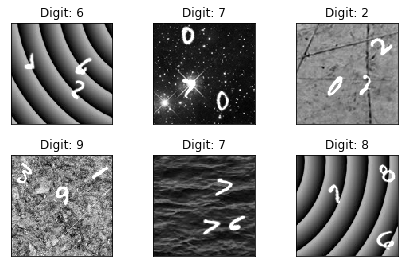

In [7]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(train_images[i], cmap='gray', interpolation='none')
  plt.title("Digit: {}".format(labels.iloc[i,1]))
  plt.xticks([])
  plt.yticks([])

In [8]:
print(train_images[0])

[[144. 153. 161. ...  58.  62.  67.]
 [144. 152. 160. ...  51.  59.  64.]
 [143. 151. 158. ...  46.  57.  62.]
 ...
 [160. 176. 172. ... 155. 163. 162.]
 [161. 167. 172. ... 147. 153. 154.]
 [156. 163. 168. ... 142. 147. 149.]]


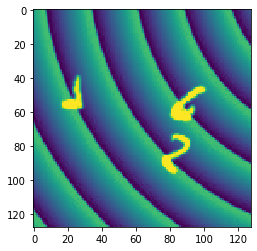

In [9]:
plt.imshow(train_images[0],interpolation='none')

In [10]:
type(train_images)

numpy.ndarray

In [11]:
print(train_images[0])

[[144. 153. 161. ...  58.  62.  67.]
 [144. 152. 160. ...  51.  59.  64.]
 [143. 151. 158. ...  46.  57.  62.]
 ...
 [160. 176. 172. ... 155. 163. 162.]
 [161. 167. 172. ... 147. 153. 154.]
 [156. 163. 168. ... 142. 147. 149.]]


In [0]:
X_train = train_images.copy()

In [0]:
X_test = test_images.copy()

In [14]:
type(X_train)

numpy.ndarray

In [0]:
for i in range(X_train.shape[0]):
  ret,bin = cv2.threshold(X_train[i],230,255,cv2.THRESH_BINARY)
  X_train[i] = bin;

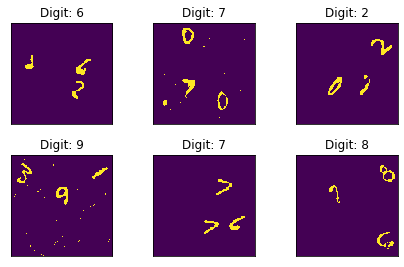

In [16]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(X_train[i], interpolation='none')
  plt.title("Digit: {}".format(labels.iloc[i,1]))
  plt.xticks([])
  plt.yticks([])

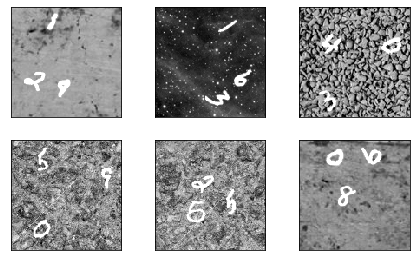

In [17]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(X_test[i], cmap='gray', interpolation='none')
  plt.xticks([])
  plt.yticks([])

In [0]:
X_train = X_train.reshape(X_train.shape[0], 128, 128, 1)
input_shape = (128, 128, 1)
# Making sure that the values are float so that we can get decimal points after division
X_train = X_train.astype('float32')
# Normalizing the RGB codes by dividing it to the max RGB value.
X_train /= 255

In [0]:
for i in range(X_test.shape[0]):
  ret,bin = cv2.threshold(X_test[i],230,255,cv2.THRESH_BINARY)
  X_test[i] = bin;

In [0]:
X_test = X_test.reshape(X_test.shape[0], 128, 128, 1)
X_test = X_test.astype('float32')
X_test /= 255

In [0]:
y_train = keras.utils.to_categorical(labels.iloc[:,1])

In [22]:
print(y_train[4].argmax())

7


In [23]:
print(X_train[2].mean())

0.026916504


In [24]:
# Model 1 starts
input_shape = Input(shape=input_shape) 
layer1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(input_shape) 
layer2 = Conv2D(64, (3, 3), activation='relu')(layer1) 
layer3 = MaxPooling2D(pool_size=(3, 3))(layer2) 
layer4 = Dropout(0.5)(layer3) 
layer5 = Flatten()(layer4) 
layer6 = Dense(250, activation='sigmoid')(layer5) 
layer7 = Dense(10, activation='softmax')(layer6) 

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model = Model([input_shape], layer7) 
model.compile(optimizer=keras.optimizers.Adadelta(), 
              loss=keras.losses.categorical_crossentropy, 
              metrics=['accuracy']) 
  
model.fit(X_train, y_train, epochs=12, batch_size=500) 

# Model 1 training ends

Instructions for updating:
Use tf.cast instead.
Epoch 1/12
 1000/50000 [..............................] - ETA: 45:56 - loss: 2.2467 - acc: 0.1610

In [0]:
# Model 2 starts (Not good)
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(128, 128, 1)))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# fit model
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=2)

# Model 2 training ends

In [28]:
pred = model.predict(X_test, verbose=1)

10000/10000 [==============================] - 8s 773us/step


In [0]:
pred_class = np.argmax(pred,axis=1)

In [43]:
pred_class[:20]

array([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 6, 9, 9, 9, 9, 9, 6, 7, 9, 9])

In [67]:
print(X_train.shape)

(50000, 128, 128, 1)


In [0]:
### Model 3 start (Using pre trained vgg in cnn.....taking long to run on colab)
# Did below to make gray as rgb
X_train_rgb = np.repeat(X_train[..., np.newaxis], 3, -1)

In [0]:
X_train_rgb = X_train_rgb.reshape(50000, 128, 128, 3)

In [0]:
image_shape_rgb = (128,128,3)
num_classes = 10
from IPython.display import SVG


In [24]:
# Pre trained VGG19
vgg_model = applications.VGG19(include_top=False, weights='imagenet', input_shape=image_shape_rgb)
display(vgg_model.summary())
bottleneck_path = r'../working/bottleneck_features_train_vgg19.npy'

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
bloc

None

In [25]:
# Set to false the layers except the last set of conv laer and their pooling
for layer in vgg_model.layers[:-5]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f02d9065f60> False
<keras.layers.convolutional.Conv2D object at 0x7f02d90e02b0> False
<keras.layers.convolutional.Conv2D object at 0x7f02d90d3780> False
<keras.layers.pooling.MaxPooling2D object at 0x7f02d906d0b8> False
<keras.layers.convolutional.Conv2D object at 0x7f02d906dcc0> False
<keras.layers.convolutional.Conv2D object at 0x7f02d88465c0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f02d885d748> False
<keras.layers.convolutional.Conv2D object at 0x7f02d885dda0> False
<keras.layers.convolutional.Conv2D object at 0x7f02d88076d8> False
<keras.layers.convolutional.Conv2D object at 0x7f02d881ebe0> False
<keras.layers.convolutional.Conv2D object at 0x7f02d87cc940> False
<keras.layers.pooling.MaxPooling2D object at 0x7f02d8763438> False
<keras.layers.convolutional.Conv2D object at 0x7f02de98a7f0> False
<keras.layers.convolutional.Conv2D object at 0x7f02daef5898> False
<keras.layers.convolutional.Conv2D object at 0x7f02daf0d828>

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


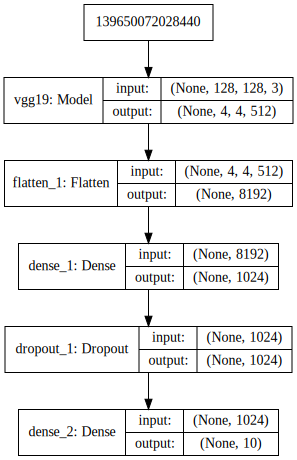

In [26]:
# fix random seed for reproducibility
seed = 101
np.random.seed(seed)

# Create the model
clf_model = Sequential()
 
# Add the vgg convolutional base model
#clf_model.add(Flatten(input_shape=bottleneck_features_train.shape[1:]))
clf_model.add(vgg_model)

# Add new layers
clf_model.add(Flatten())
clf_model.add(Dense(1024, activation='relu'))
clf_model.add(Dropout(0.5))
clf_model.add(Dense(num_classes, activation='softmax'))

SVG(model_to_dot(clf_model, show_shapes=True, show_layer_names=True, rankdir='TB').create(prog='dot', format='svg'))

In [0]:
#training
batch_size = 128
epochs = 12
lrate = 0.1
epsilon=1e-08
decay=1e-4
#opt_rms = optimizers.rmsprop(lr=lrate,decay=1e-4)
optimizer = keras.optimizers.Adadelta(lr=lrate ) # decay=decay) #, epsilon=epsilon, 
#optimizer = keras.optimizers.Adam(lr=lrate, beta_1=0.9, beta_2=0.999, epsilon=epsilon, decay=decay)

clf_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = clf_model.fit(X_train_rgb, y_train, batch_size=batch_size, epochs=epochs, verbose=1)